In [1]:
# %load_ext lab_black

In [4]:
%reload_ext autoreload
%autoreload 1
import sklearn

sklearn.set_config(transform_output="pandas")
import category_encoders as ce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as myFunc
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.graphics.gofplots import qqplot

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    cross_validate,
)
from sklearn.metrics import mean_squared_error
from sklearn import set_config

import optuna
from joblib import dump
from pycaret.regression import *

In [7]:
pd.set_option("float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
# set_config(display="diagram")

# Modeling of interest rate using just important features

In [8]:
accepted_loan_df1 = pd.read_csv(
    "accepted_2007_to_2018Q4.csv", header=0, skiprows=lambda i: i % 3 != 0
)


C:\Users\jonyt\AppData\Local\Temp\ipykernel_13616\168276497.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_loan_df1 = pd.read_csv(


In [9]:
accepted_loan_df1.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68341763,NaN,20000.00,20000.00,20000.00,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.00,Aug-2000,695.00,699.00,0.00,NaN,NaN,6.00,0.00,7869.00,56.20,18.00,w,0.00,0.00,22705.92,22705.92,20000.00,2705.92,0.00,0.00,0.00,Jun-2017,15813.30,NaN,Mar-2019,704.00,700.00,0.00,NaN,1.00,Joint App,71000.00,13.85,Not Verified,0.00,0.00,189699.00,0.00,1.00,0.00,4.00,19.00,10827.00,73.00,0.00,2.00,2081.00,65.00,14000.00,2.00,5.00,1.00,6.00,31617.00,2737.00,55.90,0.00,0.00,125.00,184.00,14.00,14.00,5.00,101.00,NaN,10.00,NaN,0.00,2.00,3.00,2.00,4.00,6.00,4.00,7.00,3.00,6.00,0.00,0.00,0.00,0.00,100.00,50.00,0.00,0.00,218418.00,18696.00,6200.00,14877.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68426831,NaN,11950.00,11950.00,11950.00,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.00,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,300xx,GA,10.20,0.00,Oct-1987,690.00,694.00,0.00,NaN,NaN,5.00,0.00,8822.00,68.40,6.00,w,0.00,0.00,13708.95,13708.95,11950.00,1758.95,0.00,0.00,0.00,May-2017,7653.56,NaN,May-2017,759.00,755.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,12798.00,0.00,1.00,0.00,0.00,338.00,3976.00,99.00,0.00,0.00,4522.00,76.00,12900.00,0.00,0.00,0.00,0.00,2560.00,844.00,91.00,0.00,0.00,338.00,54.00,32.00,32.00,0.

In [10]:
accepted_loan_df1.shape


(753567, 151)

In [12]:
cleaned_df_accepted = (
    accepted_loan_df1.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(
        myFunc.date_split_to_Y_M,
        [
            "issue_d",
        ],
    )
    .pipe(myFunc.replace_what_with_what, "term", " months", "")
    .pipe(myFunc.employment_Length_to_numeric, "emp_length")
    .pipe(
        myFunc.months_sin_cos,
        [
            "Month_issue_d",
        ],
    )
    .pipe(myFunc.log_feature, "loan_amnt")
    .pipe(myFunc.calc_risk, "fico_range_low", "fico_range_high")
    .pipe(myFunc.calc_risk, "sec_app_fico_range_low", "sec_app_fico_range_high")
    .pipe(myFunc.calc_risk, "last_fico_range_low", "last_fico_range_high")
    .pipe(
        myFunc.drop_columns,
        [
            "id",
            "member_id",
            "url",
            "purpose",
            "emp_title",
            "desc",
            "title",
            "zip_code",
            "addr_state",
            "policy_code",
            "Month_issue_d",
            "next_pymnt_d",
            "earliest_cr_line",
            "sec_app_earliest_cr_line",
            "last_credit_pull_d",
            "issue_d",
            "last_pymnt_d",
            "next_pymnt_d",
            "settlement_date",
            "debt_settlement_flag_date",
            "hardship_end_date",
            "payment_plan_start_date",
            "hardship_start_date",
            "fico_range_low",
            "fico_range_high",
            "sec_app_fico_range_low",
            "sec_app_fico_range_high",
            "last_fico_range_low",
            "last_fico_range_high",
            "revol_bal_joint",
            "tax_liens",
            "sec_app_num_rev_accts",
            "sec_app_mths_since_last_major_derog",
            "orig_projected_additional_accrued_interest",
            "num_tl_120dpd_2m",
            "hardship_amount",
            "settlement_term",
            "sec_app_chargeoff_within_12_mths",
            "collections_12_mths_ex_med",
            "hardship_payoff_balance_amount",
            "hardship_length",
            "delinq_amnt",
            "sec_app_open_act_il",
            "sec_app_inq_last_6mths",
            "chargeoff_within_12_mths",
            "settlement_amount",
            "hardship_dpd",
            "num_tl_30dpd",
            "acc_now_delinq",
            "settlement_percentage",
            "dti_joint",
            "sec_app_collections_12_mths_ex_med",
            "sec_app_open_acc",
            "sec_app_mort_acc",
            "sec_app_revol_util",
            "annual_inc_joint",
            "deferral_term",
            "hardship_last_payment_amount",
            "hardship_status",
            "hardship_type",
            "verification_status",
            "settlement_status",
            "hardship_loan_status",
            "hardship_flag",
            "pymnt_plan",
            "application_type",
            "debt_settlement_flag",
            "loan_status",
            "hardship_reason",
            "acc_open_past_24mths",
            "all_util",
            "annual_inc",
            "avg_cur_bal",
            "bc_open_to_buy",
            "bc_util",
            "cos_Month_issue_d",
            "dti",
            "emp_length",
            "funded_amnt",
            "funded_amnt_inv",
            "il_util",
            "inq_last_12m",
            "inq_last_6mths",
            "installment",
            "last_pymnt_amnt",
            "initial_list_status",
            "disbursement_method",
            "loan_amnt",
            "log_loan_amnt",
            "max_bal_bc",
            "mo_sin_old_il_acct",
            "mo_sin_old_rev_tl_op",
            "mo_sin_rcnt_rev_tl_op",
            "mo_sin_rcnt_tl",
            "mths_since_last_delinq",
            "mths_since_rcnt_il",
            "mths_since_recent_bc",
            "mths_since_recent_inq",
            "num_bc_tl",
            "num_il_tl",
            "num_rev_accts",
            "num_tl_op_past_12m",
            "open_rv_24m",
            "out_prncp",
            "out_prncp_inv",
            "pct_tl_nvr_dlq",
            "percent_bc_gt_75",
            "revol_bal",
            "revol_util",
            "risk_score",
            "sin_Month_issue_d",
            "term",
            "tot_cur_bal",
            "tot_hi_cred_lim",
            "total_acc",
            "total_bal_ex_mort",
            "total_bal_il",
            "total_bc_limit",
            "total_il_high_credit_limit",
            "total_pymnt",
            "total_pymnt_inv",
            "total_rec_int",
            "total_rec_prncp",
            "total_rev_hi_lim",
            "Year_issue_d",
        ],
    )
    .pipe(myFunc.drop_rows_if_nan, "grade")
    .pipe(myFunc.drop_rows_if_nan, "sub_grade")
    .pipe(myFunc.drop_rows_if_nan, "int_rate")
    .pipe(
        myFunc.drop_columns,
        [
            "sub_grade",
            "grade",
        ],
    )  # Please do not forget to drop different correlated targets for other models!
)


In [13]:
cleaned_df_accepted.shape


(753557, 31)

## Spliting into train, test and validation sets

Let's split data into training and testing sets.

In [16]:
df_train, df_test_val = train_test_split(
    cleaned_df_accepted,
    test_size=0.3,
    random_state=2,
)
df_test, df_val = train_test_split(
    df_test_val,
    test_size=0.5,
    random_state=3,
)


In [17]:
X_train = df_train.drop(["int_rate"], axis=1)
y_train = df_train["int_rate"]
X_test = df_test.drop(["int_rate"], axis=1)
y_test = df_test["int_rate"]
X_val = df_val.drop(["int_rate"], axis=1)
y_val = df_val["int_rate"]


In [18]:
X_train.shape, X_test.shape, X_val.shape


((527489, 30), (113034, 30), (113034, 30))

In [19]:
y_train.shape, y_test.shape, y_val.shape


((527489,), (113034,), (113034,))

## Columns selection

In [20]:
numeric_cols2 = X_train.select_dtypes(include=np.number).columns.to_list()


In [21]:
dummy_cols = list(set(X_train.columns) - set(numeric_cols2))


In [22]:
categorical_transformer = Pipeline(
    [
        (
            "rare_categorical_replace",
            ColumnTransformer(
                [
                    (
                        "rare_cat_replace",
                        FunctionTransformer(
                            myFunc.replace_rare_categorical_values,
                            validate=False,
                        ),
                        dummy_cols,
                    ),
                ]
            ),
        ),
        (
            "imputer",
            SimpleImputer(
                missing_values=np.nan,
                strategy="constant",
                fill_value="-9999",
            ),
        ),
        ("onehot_encoder", ce.OneHotEncoder()),
    ]
)


In [23]:
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-9999),
        )
    ]
)


In [24]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ("numeric_transformer", numeric_transformer, numeric_cols2),
        ("onehot", categorical_transformer, dummy_cols),
    ],
    remainder="passthrough",
)


In [25]:
final_pipeline = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
    ]
)


### Base models

In [26]:
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
fit_time_list = []
regressors_list = [
    "XGB Regressor",
    "LGBM Regressor",
]


models = [
    XGBRegressor(),
    LGBMRegressor(force_col_wise=True),
]

cv = KFold(n_splits=5, random_state=1, shuffle=True)

for model in models:
    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            ("regressor", model),
        ]
    )
    result = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=(
            "neg_mean_absolute_error",
            "neg_mean_squared_error",
            "neg_root_mean_squared_error",
            "r2",
        ),
    )

    fit_time_list.append(result["fit_time"].mean())
    mae_list.append(result["test_neg_mean_absolute_error"].mean() * -1)
    mse_list.append(result["test_neg_mean_squared_error"].mean() * -1)
    rmse_list.append(result["test_neg_root_mean_squared_error"].mean() * -1)
    r2_list.append(result["test_r2"].mean())


[LightGBM] [Info] Total Bins 2171
[LightGBM] [Info] Number of data points in the train set: 421991, number of used features: 35
[LightGBM] [Info] Start training from score 13.089742
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 421991, number of used features: 35
[LightGBM] [Info] Start training from score 13.088771
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 421991, number of used features: 35
[LightGBM] [Info] Start training from score 13.087066
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 421991, number of used features: 35
[LightGBM] [Info] Start training from score 13.085655
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 421992, number of used features: 35
[LightGBM] [Info] Start training from score 13.092392


In [27]:
base_models = pd.DataFrame(
    {
        "Mean_absolute_error": mae_list,
        "Mean_squared_error": mse_list,
        "Root_mean_squared_error": rmse_list,
        "R2": r2_list,
        "Fit time": fit_time_list,
    },
    index=regressors_list,
)


In [28]:
base_models


,Mean_absolute_error,Mean_squared_error,Root_mean_squared_error,R2,Fit time
XGB Regressor,3.48,19.83,4.45,0.15,4.48
LGBM Regressor,3.48,19.77,4.45,0.15,5.76


By theory RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. So none of our base models are predicting well.

XGB Regressor showed best results and also was fast. I will tune this model.

## XGB  hyperparameters tuning

In [29]:
X_transformed2 = final_pipeline.fit_transform(X_train)


In [30]:
def XGB_regressor_objective(trial, X: pd.DataFrame, y: pd.DataFrame) -> float:
    """Takes as an input pd.DataFrames with features and outcome, gives the best scores after training and cross validation.

    :params: trial : a process of evaluating an objective function;
            X: pd.DataFrame with independent features (predictors);
            y: pd.DataFrame with the outcome (what to predict);
    :returns: the score: neg_root_mean_squared_error, multiplied by -1
    """

    param = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.01, 1.0),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1.0),
        "random_state": trial.suggest_int("random_state", 1, 1000),
    }

    cv = KFold(n_splits=3, random_state=123, shuffle=True)

    pipeline = Pipeline(
        steps=[
            ("estimator", XGBRegressor(**param)),
        ]
    )

    score = cross_val_score(
        pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return score * -1


In [31]:
study = optuna.create_study(direction="minimize", study_name="XGBRegressor")
func = lambda trial: XGB_regressor_objective(trial, X_transformed2, y_train)
study.optimize(func, n_trials=30)


[I 2023-10-20 14:26:25,107] A new study created in memory with name: XGBRegressor


[I 2023-10-20 14:27:21,796] Trial 0 finished with value: 4.493968176890916 and parameters: {'max_depth': 7, 'learning_rate': 0.9381552410671823, 'n_estimators': 852, 'min_child_weight': 8, 'gamma': 0.038087231890418655, 'subsample': 0.9409396936580053, 'colsample_bytree': 0.017205037307669303, 'reg_alpha': 0.653821413200864, 'reg_lambda': 0.22541153370838285, 'random_state': 448}. Best is trial 0 with value: 4.493968176890916.
[I 2023-10-20 14:29:22,678] Trial 1 finished with value: 5.626994143915039 and parameters: {'max_depth': 10, 'learning_rate': 0.5626061435577433, 'n_estimators': 885, 'min_child_weight': 4, 'gamma': 0.15740080791419306, 'subsample': 0.618210647177367, 'colsample_bytree': 0.5649925989930236, 'reg_alpha': 0.5701760792896584, 'reg_lambda': 0.41571867269699375, 'random_state': 464}. Best is trial 0 with value: 4.493968176890916.
[I 2023-10-20 14:29:39,979] Trial 2 finished with value: 4.468277877567661 and parameters: {'max_depth': 2, 'learning_rate': 0.1423532420779

Let's see resuls of Optuna hyperparameter search.

In [32]:
trial = study.best_trial
params_best = trial.params

for key, value in params_best.items():
    print(f"\t\t{key}: {value}")

print(f"\tBest value of RMSE: {study.best_value:.5f}")


		max_depth: 9
		learning_rate: 0.011906881530374114
		n_estimators: 771
		min_child_weight: 2
		gamma: 0.8632430692442241
		subsample: 0.20506333153524287
		colsample_bytree: 0.8597700983684942
		reg_alpha: 0.3728559272714797
		reg_lambda: 0.25674959502106576
		random_state: 853
	Best value of RMSE: 4.44078


Now let's refit the model with best parameters.

In [33]:
xgb_reg_int_rate = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        ("regressor", XGBRegressor(**params_best)),
    ]
)

xgb_reg_int_rate.fit(X_train, y_train)


Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant'))]),
                                                  ['delinq_2yrs',
                                                   'mths_since_last_record',
                                                   'open_acc', 'pub_rec',
                                                   'total_rec_late_fee',
                                                   'recoveries',
                                                   'collection_recovery_fee',
                                                   'mths_since_last_major_derog',
                                                   'tot_...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.011906881530374114, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=2, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=771, n_jobs=None,
                              num_parallel_tree=None, random_state=853, ...))])

In [34]:
y_pred_val = xgb_reg_int_rate.predict(X_val)
print(f"rmse: {np.sqrt(mean_squared_error(y_val, y_pred_val))}")


rmse: 4.4347395640219025


# Analysis of residuals

In [35]:
residuals = y_val - y_pred_val


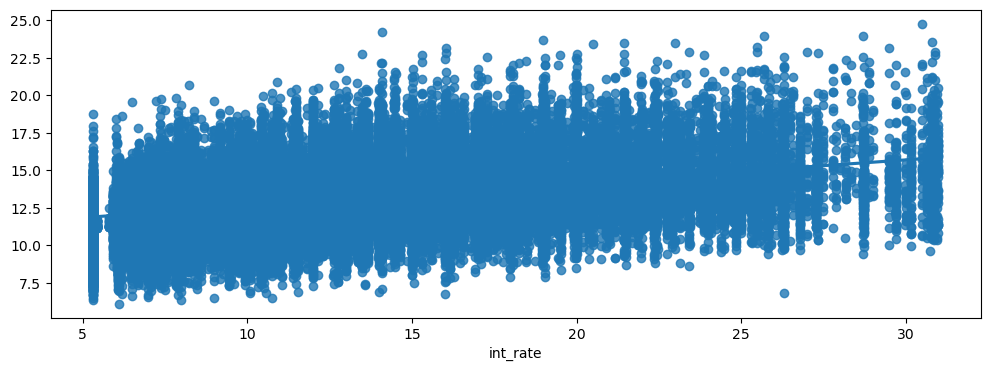

In [36]:
plt.figure(figsize=(12, 4))
sns.regplot(x=y_val, y=y_pred_val)

plt.show()


In [37]:
df_residuals = pd.DataFrame()
df_residuals["y_pred_val"] = y_pred_val
df_residuals["residuals"] = y_test - y_pred_val


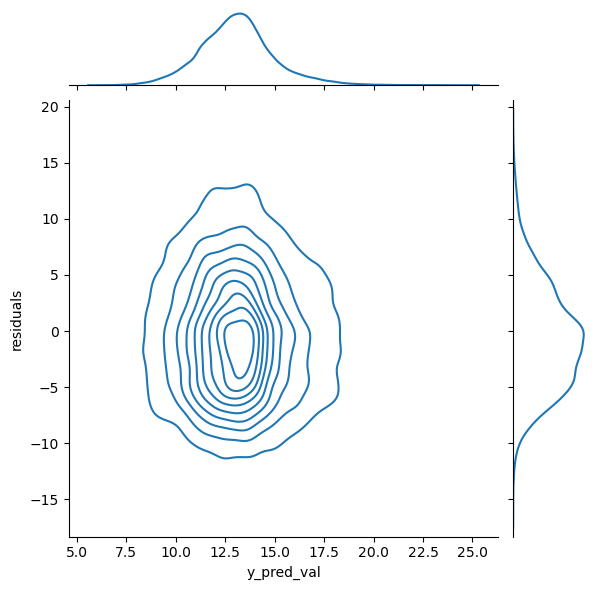

In [38]:
residuals_vs_predictions = sns.jointplot(
    data=df_residuals,
    x="y_pred_val",
    y="residuals",
    kind="kde",
)


We may see that residuals are not normally distributed, they have heavy tails on both sides.

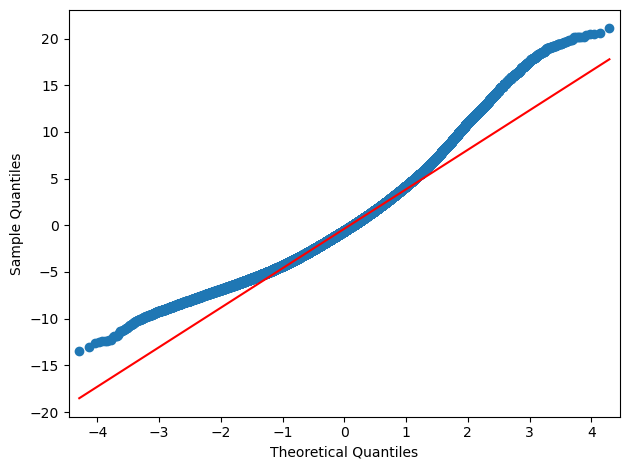

In [39]:
qq_residuals = qqplot(residuals, line="q")
plt.tight_layout()


QQ plot confirms, that the residuals distribution is right skewed.

# Predicting using test set

In [40]:
y_pred_test = xgb_reg_int_rate.predict(X_test)
print(f"rmse: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")


rmse: 4.432405385425051


By theory RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. So we faild to creade good model for int_rate predictions. Any ways, let's write it to the file.

In [41]:
dump(xgb_reg_int_rate, "int_rate_regressor.joblib")


['int_rate_regressor.joblib']

In [42]:
X_train.head()


,home_ownership,delinq_2yrs,mths_since_last_record,open_acc,pub_rec,total_rec_late_fee,recoveries,collection_recovery_fee,mths_since_last_major_derog,verification_status_joint,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,inq_fi,total_cu_tl,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,pub_rec_bankruptcies
172305,MORTGAGE,3.00,NaN,7.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,2.00,0.00,1.00,0.00,1.00,0.00,3.00,44.00,44.00,0.00,2.00,3.00,3.00,4.00,3.00,7.00,0.00,0.00
680442,MORTGAGE,0.00,NaN,11.00,0.00,0.00,0.00,0.00,64.00,NaN,0.00,2.00,7.00,2.00,2.00,0.00,0.00,0.00,0.00,64.00,64.00,1.00,2.00,3.00,2.00,4.00,3.00,11.00,0.00,0.00
553926,RENT,0.00,NaN,9.00,0.00,0.00,0.00,0.00,84.00,NaN,0.00,0.00,1.00,0.00,1.00,2.00,1.00,0.00,0.00,84.00,37.00,1.00,4.00,7.00,4.00,8.00,7.00,9.00,0.00,0.00
341490,RENT,0.00,NaN,8.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,1.00,2.00,1.00,2.00,0.00,0.00,4.00,1.00,NaN,NaN,0.00,2.00,5.00,2.00,6.00,5.00,8.00,0.00,0.00
490653,OWN,0.00,NaN,7.00,0.00,0.00,0.00,0.00,38.00,NaN,0.00,1.00,1.00,0.00,1.00,2.00,1.00,0.00,0.00,65.00,65.00,2.00,4.00,5.00,4.00,6.00,5.00,7.00,0.00,0.00


most important features for interest rate prediction:
- total_rec_int
- term
- total_rec_prncp
- risk_score
- installment

We successfully improved the rmse from 4.45 to 4.43 by fine-tuning the hyperparameters for the XGBoost regressor. To ckeck if this represents the best possible model resuls, lets try out PyCaret.

# PyCaret

In [5]:
df = pd.read_csv(r"to_model_1int.csv")
df = df.drop("Unnamed: 0", axis=1)
df.head()


,int_rate,home_ownership,delinq_2yrs,mths_since_last_record,open_acc,pub_rec,total_rec_late_fee,recoveries,collection_recovery_fee,mths_since_last_major_derog,verification_status_joint,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,inq_fi,total_cu_tl,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,pub_rec_bankruptcies
0,10.78,MORTGAGE,0.00,NaN,6.00,0.00,0.00,0.00,0.00,NaN,Not Verified,0.00,0.00,1.00,0.00,4.00,0.00,2.00,5.00,5.00,NaN,NaN,0.00,2.00,3.00,2.00,4.00,3.00,6.00,0.00,0.00
1,13.44,RENT,0.00,NaN,5.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,2.00,3.00,2.00,4.00,3.00,5.00,0.00,0.00
2,6.49,RENT,0.00,106.00,14.00,1.00,0.00,0.00,0.00,NaN,NaN,8341.00,2.00,1.00,0.00,0.00,2.00,2.00,0.00,1.00,NaN,NaN,0.00,6.00,9.00,7.00,13.00,9.00,14.00,0.00,1.00
3,12.88,MORTGAGE,0.00,NaN,13.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,2.00,0.00,2.00,1.00,0.00,0.00,2.00,NaN,NaN,0.00,4.00,6.00,5.00,10.00,6.00,13.00,0.00,0.00
4,6.49,MORTGAGE,0.00,NaN,16.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,2.00,0.00,0.00,0.00,0.00,1.00,2.00,48.00,42.00,0.00,7.00,9.00,9.00,13.00,9.00,16.00,0.00,0.00


In [6]:
reg = setup(data=df, target="int_rate", session_id=123)


,Description,Value
0,Session id,123
1,Target,int_rate
2,Target type,Regression
3,Original data shape,"(753557, 31)"
4,Transformed data shape,"(753557, 38)"
5,Transformed train set shape,"(527489, 38)"
6,Transformed test set shape,"(226068, 38)"
7,Numeric features,28
8,Categorical features,2
9,Rows with missing values,99.9%


In [7]:
best_model = compare_models(sort="RMSE", fold=3)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.2273,7.3529,1.5656,0.0167,0.1117,0.1076,255.8600
lightgbm,Light Gradient Boosting Machine,3.4794,19.7978,4.4495,0.1506,0.3164,0.3044,3.8900
xgboost,Extreme Gradient Boosting,3.4846,19.8771,4.4584,0.1472,0.3166,0.3042,3.7133
gbr,Gradient Boosting Regressor,3.5175,20.1517,4.4891,0.1355,0.3205,0.3103,51.2667
br,Bayesian Ridge,3.5547,20.6483,4.5440,0.1141,0.3233,0.3128,2.2467
ridge,Ridge Regression,3.5547,20.6486,4.5441,0.1141,0.3233,0.3128,1.7067
lr,Linear Regression,3.5547,20.6496,4.5442,0.1141,0.3233,0.3128,4.9567
rf,Random Forest Regressor,3.6176,21.2590,4.6107,0.0880,0.3288,0.3177,342.3000
en,Elastic Net,3.6633,22.0584,4.6966,0.0536,0.3352,0.3275,4.9233
lasso,Lasso Regression,3.7354,22.8824,4.7835,0.0183,0.3420,0.3353,5.1533


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Using PyCaret results are nearly the same like we managed to get, except for the Extra Trees Regressor, wich managed to get RMSE 1.56. 

# Conclusions


Typical Lending Club Customer Behavior:
- Lending Club's popularity continues to grow each year, with a noticeable seasonal increase in popularity a few months before Christmas.
- The majority of Lending Club clients apply for loans as individuals.
- Many Lending Club clients withdraw their loan listings before they are fully funded.
- Most Lending Club clients have never entered into a debt settlement arrangement with a creditor.  

**Predicting Accepted/Rejected Loan Requests:**

Customers with approved loans:
- Tend to have a higher mean debt-to-income ratio, about 8% higher compared to those who were rejected.
- Request a smaller mean loan amount, approximately $3,000 less than those who were rejected.
- Have a higher mean risk score, approximately 70 points higher than those who were rejected.
- Generally, have employment lengths exceeding one year. It's worth noting that clients with 5 years of employment history are around 50% less likely to get a loan compared to those with 4 years of employment.
- The most important features in predicting accepted/rejected loan requests are risk score, employment length less than one year, and debt-to-income ratio. An XGBoost Classifier model was successfully created with an F1 score of 0.98.

**Predicting Grades, Subgrades, and Interest Rates:**

All three of these targets are strongly correlated, and all statements apply to all.  
Several observations were made:
- Grades B and C are the most popular.
- Grades do not significantly depend on annual income.
- Higher grades tend to have higher interest rates.
- Higher grades are associated with a higher proportion of fully funded cases and debt settlement flag cases.
- Higher grades have smaller risk scores and higher values for various loan metrics.
- Modeling of Grades, Subgrades, and Interest Rates:

The most important features for grades, subgrades, and interest rates prediction are rec_int, installment, risk_score, term, total_rec_prncp, and bc_open_to_buy.

A successful XGBoost Classifier model for predicting grades achieved an F1 score of 0.76.
However, a model for predicting subgrades reached only an F1 score of 0.21 and should not be used.
For interest rate modeling, the RMSE was improved from 4.45 to 4.43 by fine-tuning the XGBoost Regressor. Consider exploring the use of the Extra Trees Regressor, as suggested by the PyCaret library.

**Suggestions for Further Project Implementation:**
- Seek a cleaner dataset with fewer missing values.
- Consider using the Extra Trees Regressor for interest rate prediction.
- Explore PyCaret for grades and subgrades predictions, as it may offer models not yet tried.
- Attempt to predict subgrades and interest rates using the predicted grade as a feature.

**Final Conclusion:**

Out of the four models created, it is advisable to use only two, specifically the XGBoost Classifier for predicting grades F1 score of 0.76 and the model for predicting accepted/rejected loan requests with an F1 score of 0.98.